# Convolutional Neural Network Classification model
## by Vesna Pop-Dimitrijoska
---

**Dataset:**          
Fashion MNIST 

**Task:**     
Convolutional Neural Network Classification model on Fashion MNIST dataset which contains 70,000 grayscale images in 10 categories. 

---
## Loading the libraries

In [1]:
import numpy as np
import pandas as pd
import random
from collections import Counter
import pathlib
import glob

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from keras.layers import Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Conv2DTranspose, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import cv2 

from keras.utils import to_categorical 
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

img_width  = 28
img_height = 28
channels   = 1

## Import the Fashion MNIST dataset:

In [2]:
from keras.datasets import fashion_mnist

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. 

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. 


The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>



## Download Data

In [3]:
# Loading the dataset and spliting in train and test segments:

(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [4]:
# Checking the shape of the splited dataset:

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

## Target class analysis 

In [5]:
print(Counter(Y_train))
print(Counter(Y_test))

Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})
Counter({9: 1000, 2: 1000, 1: 1000, 6: 1000, 4: 1000, 5: 1000, 7: 1000, 3: 1000, 8: 1000, 0: 1000})


Loading the dataset returns four NumPy arrays:

* The `X_train` and `Y_train` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `X_test`, and `Y_test` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [6]:
# Storing the dataset in order to be used later for plotting:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print([el for el in enumerate(class_names)])
# class_names_dict = {idx:v for idx, v in zip(range(len(class_names)), class_names)}
# class_names_dict = {idx:v for idx, v in enumerate(class_names)}
class_names_dict = dict(enumerate(class_names))

print(class_names_dict)


[(0, 'T-shirt/top'), (1, 'Trouser'), (2, 'Pullover'), (3, 'Dress'), (4, 'Coat'), (5, 'Sandal'), (6, 'Shirt'), (7, 'Sneaker'), (8, 'Bag'), (9, 'Ankle boot')]
{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [7]:
# Checking the results:

class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## Scaling

In [8]:
X_train_p = X_train.reshape(*X_train.shape, 1) / 255.0  # adding the channel and scaling
X_test_p = X_test.reshape(*X_test.shape, 1) / 255.0     # adding the channel and scaling
print(X_train.shape)
print(X_train_p.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


## One Hot Encoding

In [9]:
n_classes = len(set(Y_train)) # 10
Y_train_oh = to_categorical(Y_train, num_classes=n_classes)
Y_test_oh = to_categorical(Y_test, num_classes=n_classes)
print(Y_train.shape)
print(Y_train_oh.shape)

(60000,)
(60000, 10)


---
# Convolutional Neural Network - Classification model

In [10]:
model = Sequential()

# INPUT
model.add(Input((28, 28, 1)))

# CONVOLUTIONAL NN
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# CLASSIFICATION NN
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# OUTPUT
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 16)        64        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 26, 26, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 32)        0

In [11]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

## Data augmentation
- Translation relative to x axis
- Translation relative to y axis
- Horizontal Flip

In [12]:
datagen = ImageDataGenerator(
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip = True, 
)
datagen.fit(X_train_p)
datagen

## Training the model

In [13]:
es_cbk = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

model_history = model.fit(datagen.flow(X_train_p, Y_train_oh, batch_size=128),
                            epochs=500,
                            validation_data=(X_test_p, Y_test_oh),
                            callbacks=[es_cbk]
)

Epoch 1/500
469/469 [==============================] - 247s 517ms/step - loss: 0.7701 - accuracy: 0.7303 - val_loss: 0.5209 - val_accuracy: 0.8091
Epoch 2/500
469/469 [==============================] - 254s 541ms/step - loss: 0.4977 - accuracy: 0.8227 - val_loss: 0.4460 - val_accuracy: 0.8448
Epoch 3/500
469/469 [==============================] - 280s 596ms/step - loss: 0.4260 - accuracy: 0.8505 - val_loss: 0.3353 - val_accuracy: 0.8805
Epoch 4/500
469/469 [==============================] - 270s 575ms/step - loss: 0.3931 - accuracy: 0.8619 - val_loss: 0.2968 - val_accuracy: 0.8956
Epoch 5/500
469/469 [==============================] - 265s 566ms/step - loss: 0.3648 - accuracy: 0.8734 - val_loss: 0.2936 - val_accuracy: 0.8932
Epoch 6/500
469/469 [==============================] - 252s 536ms/step - loss: 0.3463 - accuracy: 0.8792 - val_loss: 0.2746 - val_accuracy: 0.9017
Epoch 7/500
469/469 [==============================] - 255s 544ms/step - loss: 0.3295 - accuracy: 0.8842 - val_loss: 0

Epoch 113/500
469/469 [==============================] - 226s 475ms/step - loss: 0.1439 - accuracy: 0.9489 - val_loss: 0.1765 - val_accuracy: 0.9420
Epoch 114/500
469/469 [==============================] - 231s 486ms/step - loss: 0.1429 - accuracy: 0.9492 - val_loss: 0.1943 - val_accuracy: 0.9382
Epoch 115/500
469/469 [==============================] - 225s 471ms/step - loss: 0.1437 - accuracy: 0.9495 - val_loss: 0.1834 - val_accuracy: 0.9393
Epoch 116/500
469/469 [==============================] - 234s 492ms/step - loss: 0.1420 - accuracy: 0.9499 - val_loss: 0.1945 - val_accuracy: 0.9361
Epoch 117/500
469/469 [==============================] - 230s 483ms/step - loss: 0.1413 - accuracy: 0.9499 - val_loss: 0.1757 - val_accuracy: 0.9429
Epoch 118/500
469/469 [==============================] - 245s 518ms/step - loss: 0.1419 - accuracy: 0.9501 - val_loss: 0.1836 - val_accuracy: 0.9385
Epoch 119/500
469/469 [==============================] - 230s 484ms/step - loss: 0.1410 - accuracy: 0.9507

Epoch 168/500
469/469 [==============================] - 174s 365ms/step - loss: 0.1265 - accuracy: 0.9553 - val_loss: 0.1894 - val_accuracy: 0.9414
Epoch 169/500
469/469 [==============================] - 170s 356ms/step - loss: 0.1248 - accuracy: 0.9565 - val_loss: 0.1880 - val_accuracy: 0.9401
Epoch 170/500
469/469 [==============================] - 898s 2s/step - loss: 0.1230 - accuracy: 0.9568 - val_loss: 0.1794 - val_accuracy: 0.9475
Epoch 171/500
469/469 [==============================] - 894s 2s/step - loss: 0.1222 - accuracy: 0.9571 - val_loss: 0.1812 - val_accuracy: 0.9442
Epoch 172/500
469/469 [==============================] - 844s 2s/step - loss: 0.1231 - accuracy: 0.9568 - val_loss: 0.1856 - val_accuracy: 0.9428
Epoch 173/500
469/469 [==============================] - 510s 1s/step - loss: 0.1226 - accuracy: 0.9569 - val_loss: 0.1839 - val_accuracy: 0.9449
Epoch 174/500
469/469 [==============================] - 252s 530ms/step - loss: 0.1246 - accuracy: 0.9566 - val_loss:

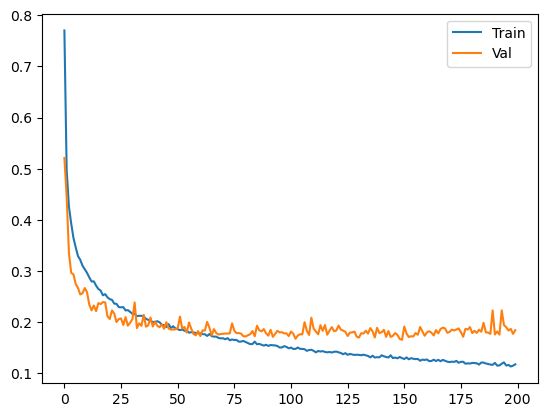

In [14]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.legend(['Train', 'Val'])
plt.show()

## Model prediction

In [15]:
Y_pred_probability = model.predict(X_test_p)
Y_pred = np.argmax(Y_pred_probability, axis=1)

313/313 [==============================] - 19s 43ms/step


## Model evaluation

Preformance metrics for CNN model:
--------------------------------------
Accuracy:            94.68 %
F1 score (macro):    94.67 %


Classification report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      1000
           1       0.99      0.99      0.99      1000
           2       0.93      0.92      0.93      1000
           3       0.95      0.94      0.94      1000
           4       0.91      0.94      0.93      1000
           5       0.99      0.99      0.99      1000
           6       0.85      0.83      0.84      1000
           7       0.96      0.98      0.97      1000
           8       0.99      1.00      0.99      1000
           9       0.98      0.97      0.98      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



Text(0.5, 1.0, 'Confusion matrix')

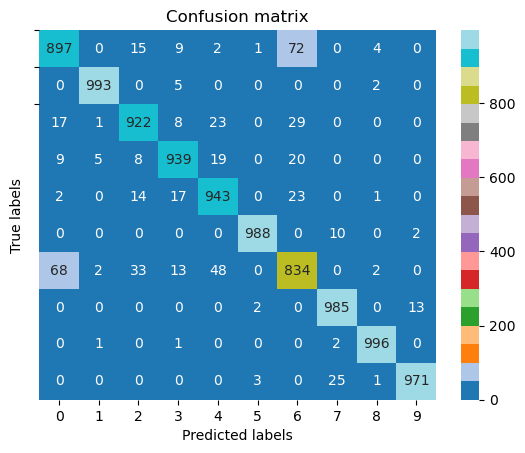

In [16]:
print('Preformance metrics for CNN model:')
print('--------------------------------------')
print('Accuracy:           ', round(((accuracy_score(Y_test, Y_pred)))*100, 2), '%')
print('F1 score (macro):   ', round((f1_score(Y_test, Y_pred, average='macro'))*100, 2), '%\n') 
print('\nClassification report:\n', classification_report(Y_test, Y_pred))

cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap = "tab20")

plt.yticks(np.arange(3))
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion matrix')

## Saving the model

In [19]:
model.save(pathlib.Path("models", 'best_model_FasionMnist'))

INFO:tensorflow:Assets written to: models\best_model_FasionMnist\assets


INFO:tensorflow:Assets written to: models\best_model_FasionMnist\assets


In [20]:
import pathlib
from keras.models import load_model

best_model_path = pathlib.Path('models', 'best_model_FasionMnist')
read_model = load_model(best_model_path)

## Analysing results for every class

In [18]:
def plot_sample_predictions_with_histogram(classes, model, X_test, Y_test, cm):
    class_ = 0
    images_per_row = 1  
    rows = len(classes) // images_per_row
    num_classes = cm.shape[0]
    report = classification_report(Y_test, Y_pred, target_names=class_names, output_dict=True)

    fig, axes = plt.subplots(rows, 2, figsize=(14, 2.5*rows))

    for i in range(rows):
       
        # Display sample image
        elements = np.squeeze(np.argwhere(Y_test==class_))
        random = np.random.randint(len(elements))
        X = X_test[elements[random]]
        Y = Y_test[elements[random]]
        
        f1 = round(list(report.values())[i]['f1-score']*100, 2)

        x_reshape = X.reshape([1, img_height, img_width, channels])
        axes[i, 0].text(0, 32, f'Predicted: {classes[np.argmax(model.predict(x_reshape))]}')
        axes[i, 0].text(0, 36, f'Correct:    {classes[Y]}')
        axes[i, 0].text(0, 40, f'F1 score:  {f1}%')
        axes[i, 0].text(0, 42, ' ')
        axes[i, 0].imshow(np.squeeze(X), cmap='gray')
        axes[i, 0].axis('off')

        # Display histogram
        class_predictions = cm[class_]
        colors = ['magenta'] * num_classes

        most_common_class = np.argmax(class_predictions)
        colors[most_common_class] = 'royalblue'

        axes[i, 1].bar(range(num_classes), class_predictions, color=colors)
        axes[i, 1].set_title(f'Predictions for Class: {i} - {class_names_dict[class_]}')  
        
        shortened_class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'AnkleBoot']

        axes[i, 1].set_xticks(range(num_classes))
        axes[i, 1].set_xticklabels(shortened_class_names)
        
        class_ += 1

    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 36ms/step


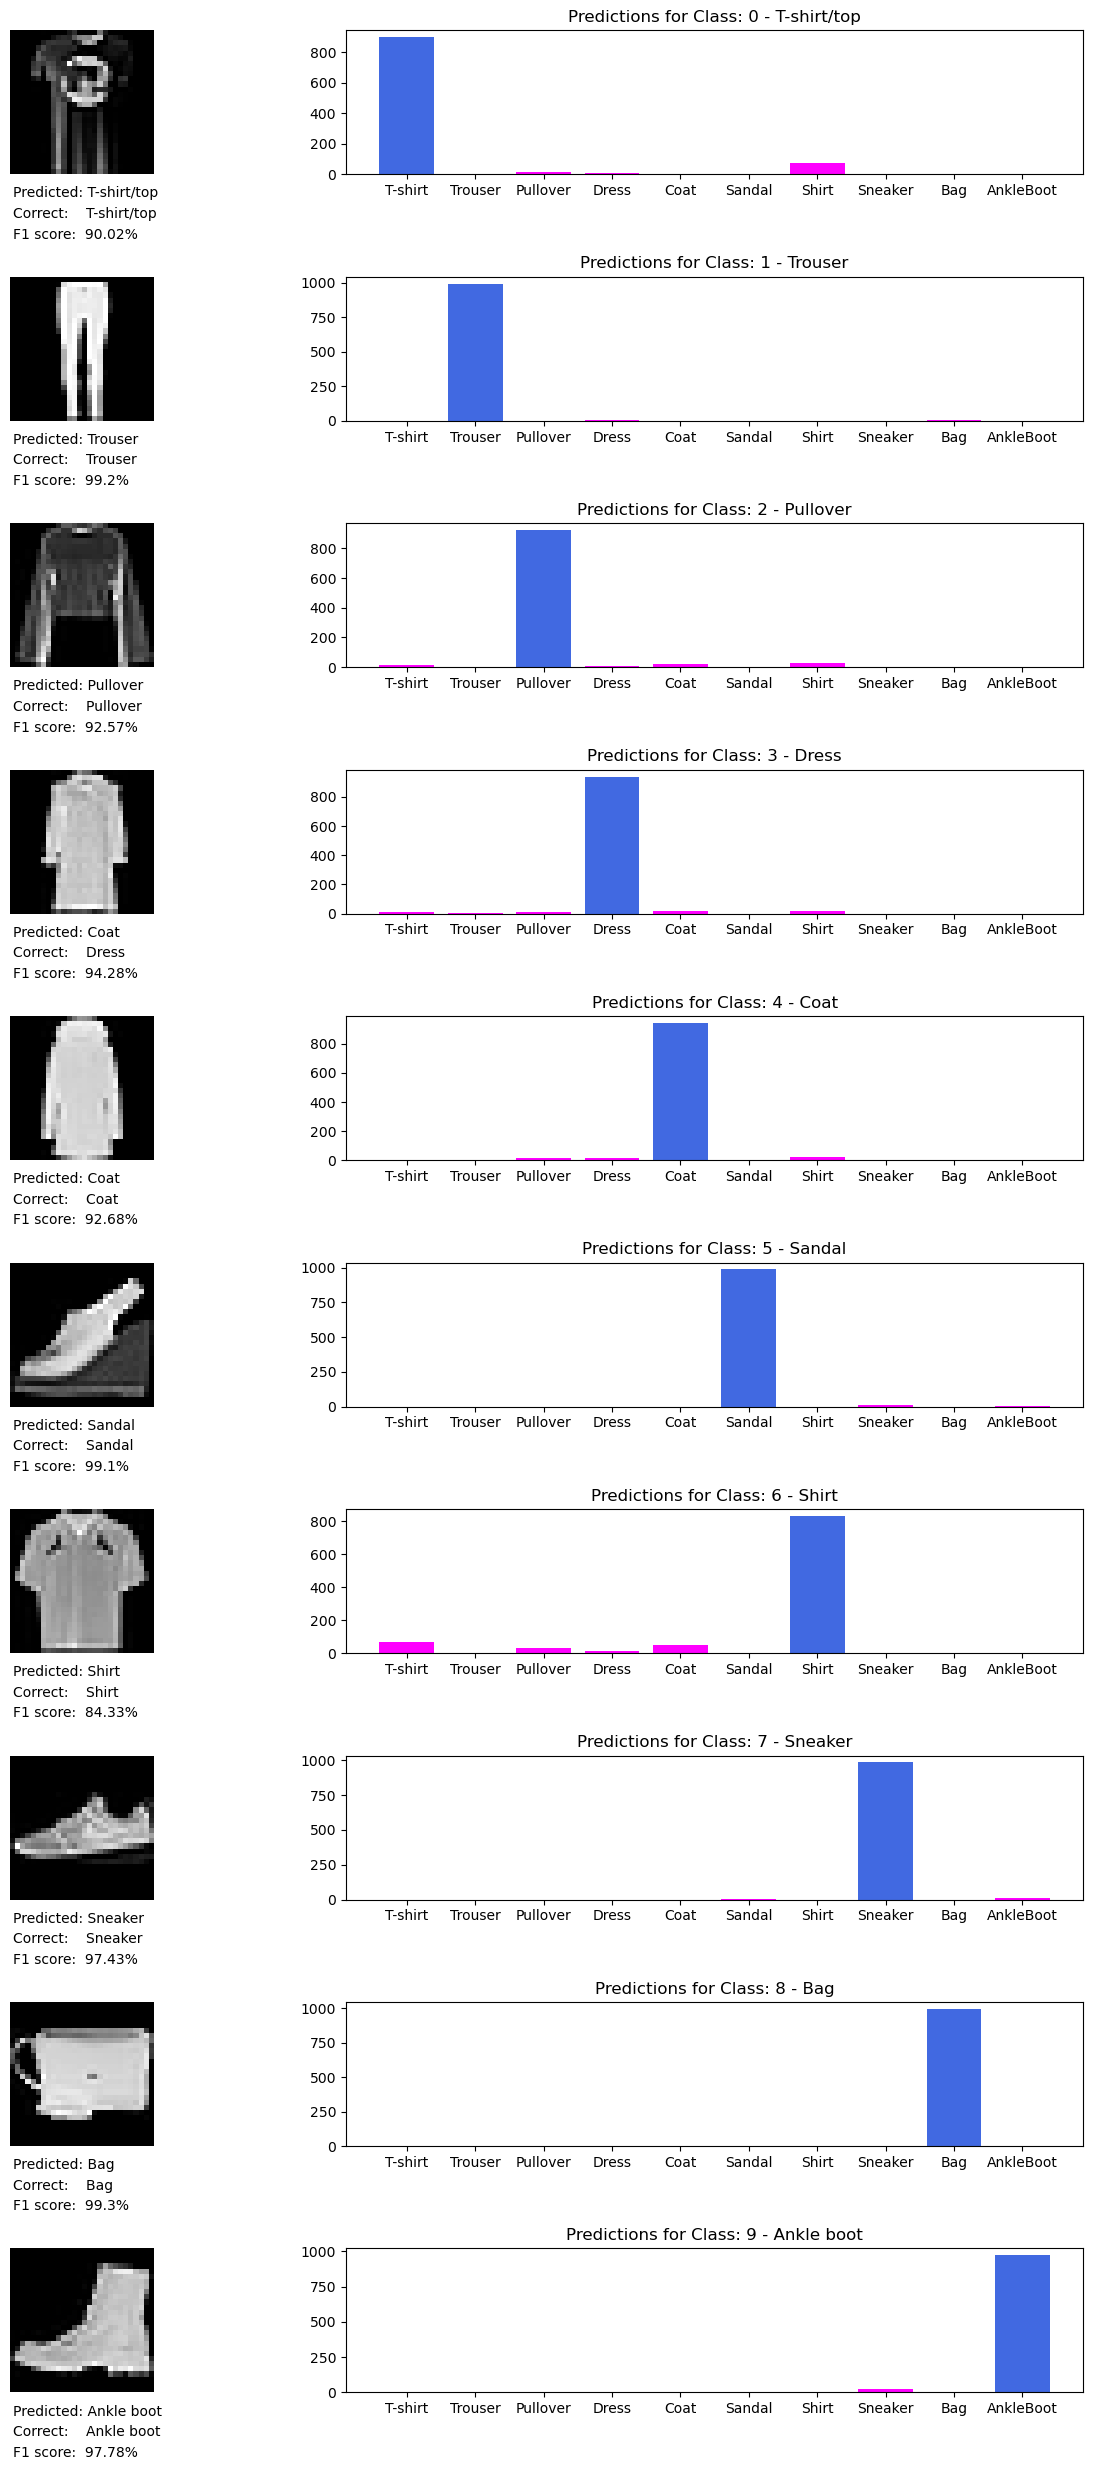

In [19]:
plot_sample_predictions_with_histogram(list(class_names_dict.values()), model, X_test_p, Y_test, cm)

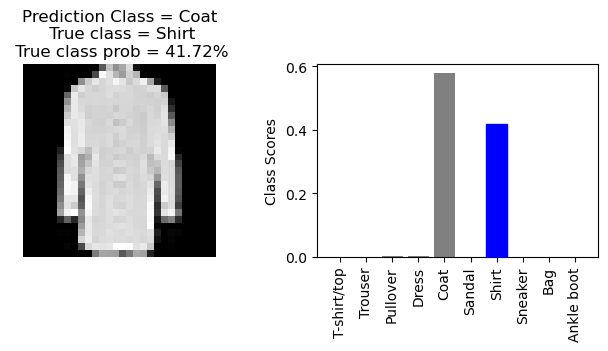

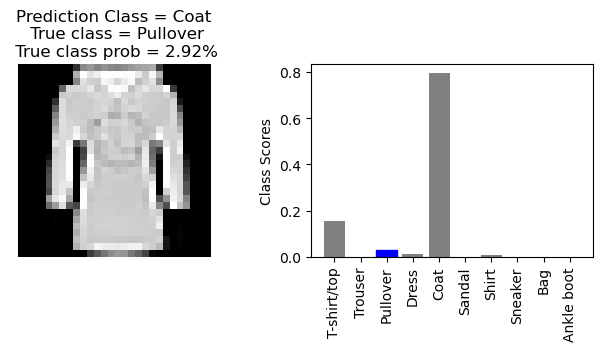

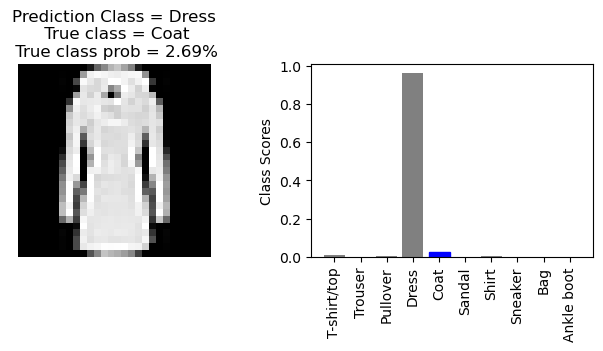

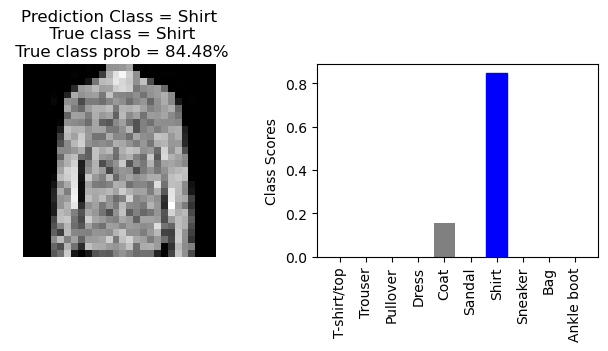

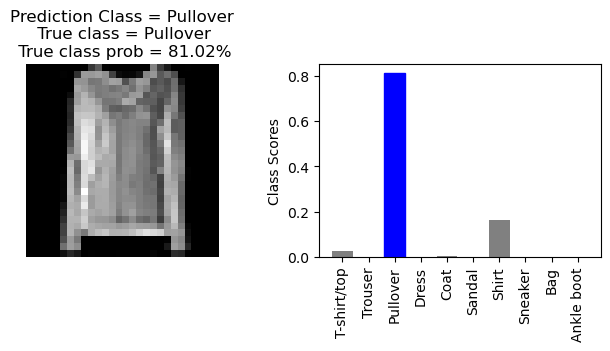

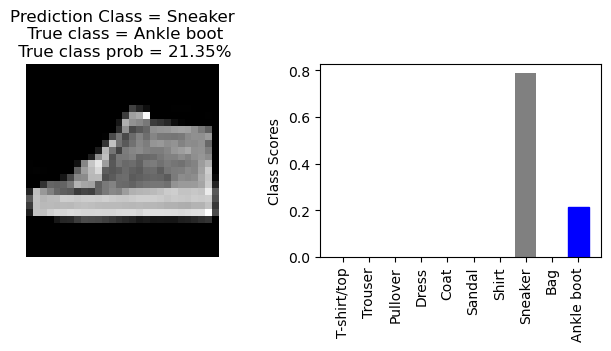

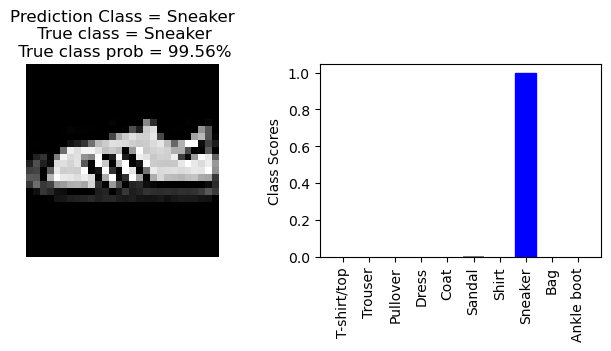

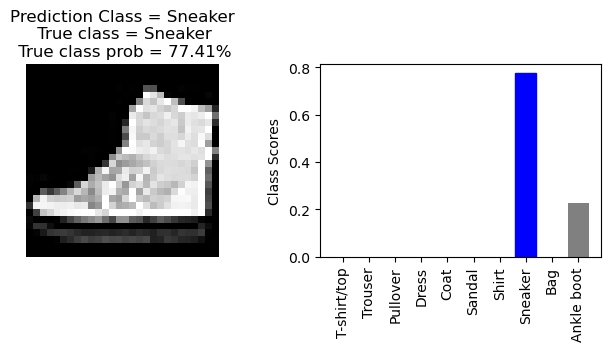

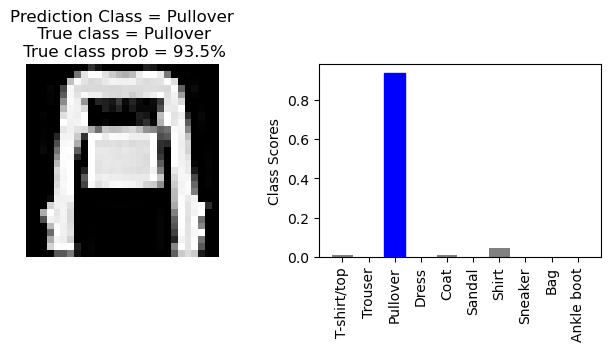

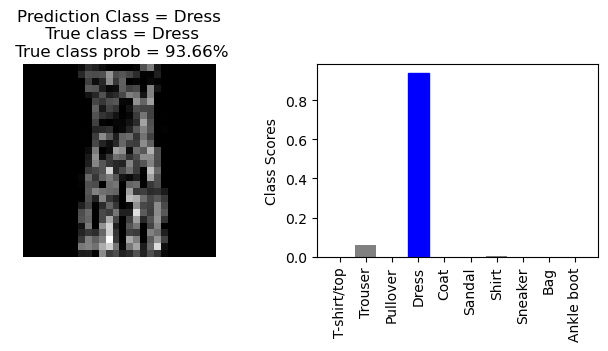

In [231]:
list_images = [444, 3258, 685, 101, 103, 107, 308, 800, 314, 560]

for i in list_images:
    
    plt.figure(figsize=(8, 2.5))

    plt.subplot(121)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f'Prediction Class = {class_names[Y_pred[i]]}\n True class = {class_names[Y_test[i]]}\n True class prob = {round(Y_pred_probability[i, Y_test[i]]*100, 2)}%')
    plt.axis('off')

    plt.subplot(122)
    bars = plt.bar(range(len(class_names)), Y_pred_probability[i], color='grey')
    bars[Y_test[i]].set_color('blue')
    plt.xticks(range(len(class_names)), class_names, rotation=90)
    plt.ylabel('Class Scores')
    plt.show()

# CONCLUSION:  

####
**Model Arhitecture**

I tested multiple architectures and one of the best performances was achived with the model shown here.

Although the MaxPooling2D filter reduces the image by half, which in our case is quite small from the start, I used it in one of the models, because I think it was convenient for this type of images, that are containing a lot of contrast, because images are white on a black background. Performance was improved by nearly 0.5%. It was left out in my final model, and I think that it would improve the final model as well.

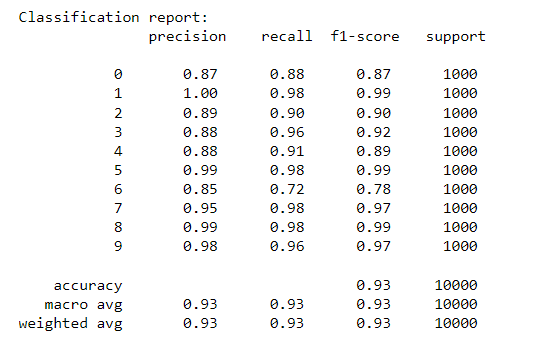

The best result was obtained using Data augmentation, although it was not recommended to use it in this kind of example, I tried it anyway to see if it would improve the result, and it did by nearly 2.5%. The training was extremly slow, so I didn't try this model combined with MaxPooling2D filter.

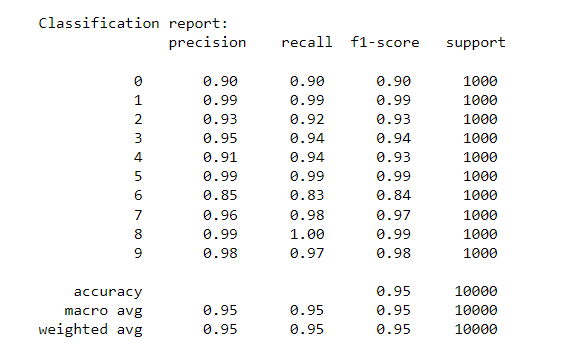

####
**Analyzing the predictions**  
    
From the histograms for each class, it is evident that the most similar classes are mixed the most: 'Shirt', 'Coat', 'Pullover', 'T-shirt/Top' and sometimes 'Dress'. The biggest confusion overal is between 'Shirt' and 'T-shirt/Top'.     
'Shirt' has lowest F1 score of all classes.
